## Definitions

In [ ]:
%matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adam, SGD
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/My Drive/Colab Notebooks/ML_DL") # might have to change path to point to your Colab Notebooks folder

Mounted at /content/gdrive


## Load and format data

Number of classes: 10
Example of handwritten digit with correlated noise: 



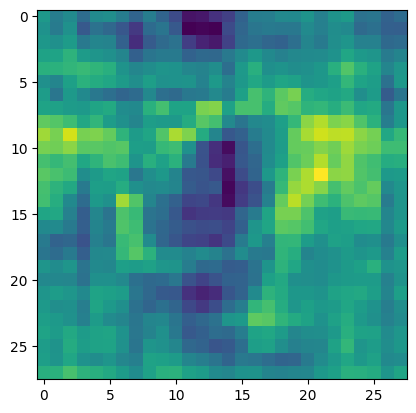

Class: 9

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [ ]:
data = np.load('./MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 3000
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and standarize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

# Data Augmentation

In [ ]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom





## Training

In [ ]:
model_name='CNN' # To compare models, you can give them different names

pweight='./weights/weights_' + model_name  + '.keras'

if not os.path.exists('./weights'):
  os.mkdir('./weights')

## EXPLORE VALUES AND FIND A GOOD SET

## here it was random

b_size = 64 # batch size
val_split = 0.2 # percentage of samples used for validation (e.g. 0.5)
ep = 20 # number of epochs

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 10, 10, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10, 10, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 5, 128)           │             5

 Total params: 529,290 (2.02 MB)

 Trainable params: 528,138 (2.01 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/20
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2548 - loss: 2.1189
Epoch 1: val_loss improved from inf to 0.56622, saving model to ./weights/weights_CNN.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.2558 - loss: 2.1159 - val_accuracy: 0.8117 - val_loss: 0.5662 - learning_rate: 0.0010
Epoch 2/20
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7790 - loss: 0.6613
Epoch 2: val_loss improved from 0.56622 to 0.33716, saving model to ./weights/weights_CNN.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 34s 20ms/step - accuracy: 0.7791 - loss: 0.6612 - val_accuracy: 0.8867 - val_loss: 0.3372 - learning_rate: 0.0010
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8421 - loss: 0.4763
Epoch 3: val_loss improved from 0.33716 to 0.30083, saving model to ./weights/weights_CNN.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8421 - loss: 0.4763 - val_accuracy: 0.8994 - val_loss: 0.3008 - learning_rate: 0.0010
Epoch 4/20
749/750 ━━━━━━━

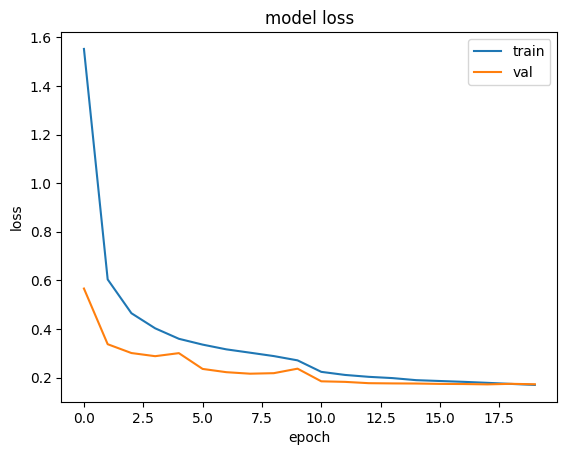

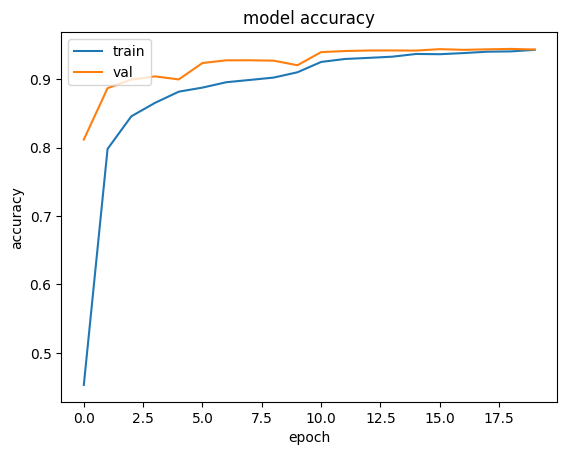

In [ ]:
input_shape = x_train.shape[1:4] #(28,28,1)

model = Sequential()

data_augmentation = Sequential([
    RandomZoom(0.1,input_shape=input_shape),       # Randomly zoom images by 20%
], name="data_augmentation")

## EXPLORE LAYERS, # CHANNELS... Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D
## SEE KERAS MANUAL https://keras.io/layers/about-keras-layers/
model.add(data_augmentation)
# Conv 1
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())

# Conv 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))




# Conv 3
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


# Conv 4
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Conv 5
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.2))


# Conv 6
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Dropout(0.5))
model.add(Flatten())
##
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))


model.add(Dense(num_cls, activation='softmax')) # This is a necessary output layer, however, you can add more dense layers before with different activation functions




model.compile(loss='categorical_crossentropy',
             optimizer=Adam(learning_rate=0.001),
             metrics=['accuracy'])





#model.compile(loss=categorical_crossentropy,
#              optimizer=Adadelta(), # explore other optimizers: Adam, SGD
 #             metrics=['accuracy'])

model.summary()

checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5)
callbacks_list = [checkpointer, reduce_lr]

history=model.fit(x_train, y_train,
                        epochs=ep,
                        batch_size=b_size,
                        verbose=1,
                        shuffle=True,
                        validation_split = val_split,
                        callbacks=callbacks_list)

print('CNN weights saved in ' + pweight)

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot accuracy vs epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


## Make predictions in test set

In [ ]:
from keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test']

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)

print('Shape of x_train: '+str(x_test.shape)+'\n')

## Define model parameters
model_name='CNN' # To compare models, you can give them different names
pweight='./weights/weights_' + model_name  + '.keras'

model = load_model(pweight)
#y_pred = model.predict_classes(x_test)
y_pred = np.argmax(model.predict(x_test), axis=1)


Acc_pred = sum(y_pred == y_test)/len(y_test)

print('Accuracy in test set is: '+str(Acc_pred))




Number of classes: 10
Shape of x_train: (10000, 28, 28, 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Accuracy in test set is: 0.947


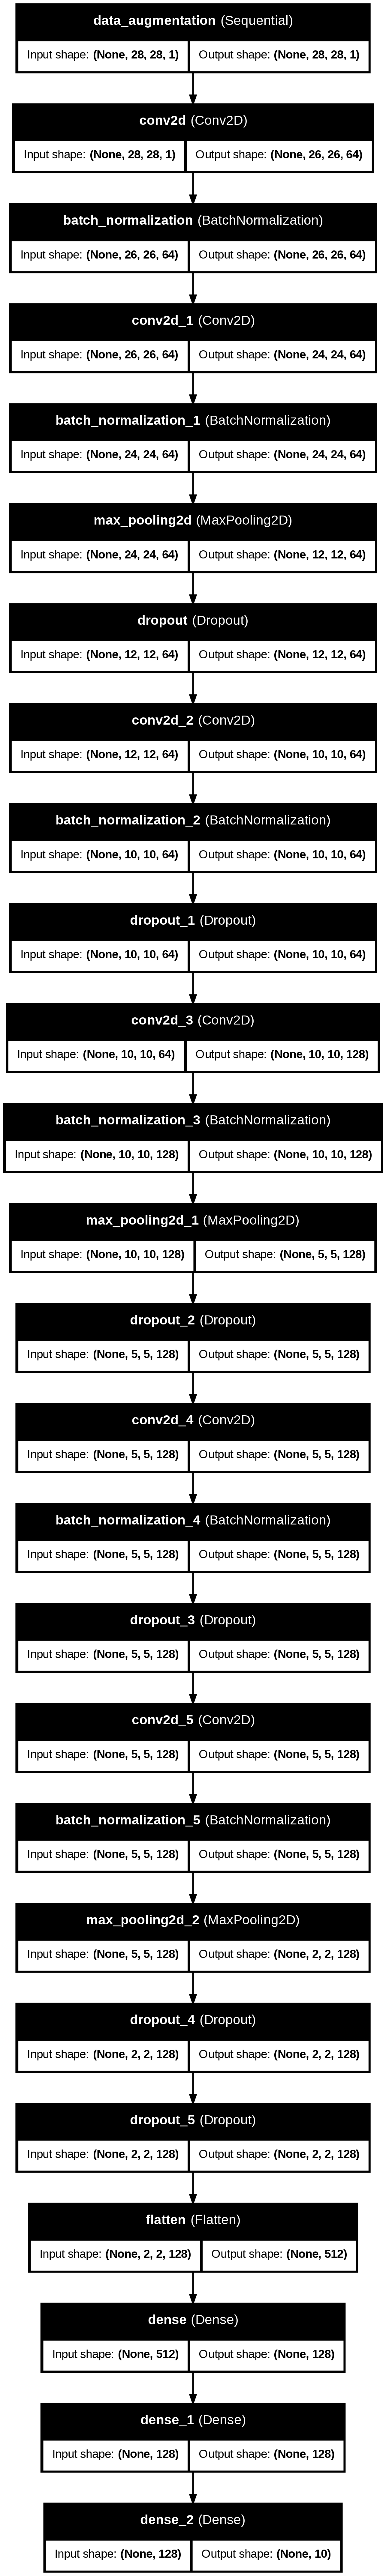

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
